In [1]:
import torch 
from torch import nn
from torch.nn import functional as F
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset =  torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())
train_dataloader = DataLoader(dataset=dataset, batch_size=8, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 124858359.87it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 118181164.71it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 111535841.64it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4337552.09it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



x shape:  torch.Size([8, 1, 28, 28])
y labels tensor([3, 7, 9, 1, 0, 2, 2, 7])


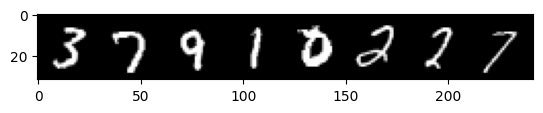

In [4]:
x, y = next(iter(train_dataloader))
print("x shape: ", x.size())
print("y labels", y)

plt.imshow(torchvision.utils.make_grid(x)[0], cmap='gray')
plt.show()

In [5]:
def corrupt(x, amount):
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)
    return x * (1 - amount) + amount * noise

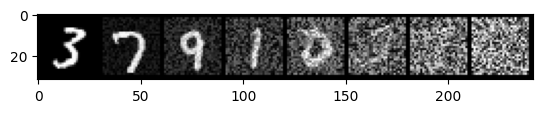

In [6]:
amount = torch.linspace(0, 1, x.shape[0])
noisy_x = corrupt(x, amount)

plt.imshow(torchvision.utils.make_grid(noisy_x)[0], cmap='gray')
plt.show()

In [7]:
class BasicUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2)
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2), 
        ])
        self.act =  nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)
    
    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:
                h.append(x)
                x = self.downscale(x)
        
        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function
            
        return x

In [8]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

In [9]:
sum([p.numel() for p in net.parameters()])

309057

Finished epoch 0 Average loss for this epoch: 0.02552971635053534
Finished epoch 1 Average loss for this epoch: 0.01960823558040583
Finished epoch 2 Average loss for this epoch: 0.01806407256810459
Finished epoch 3 Average loss for this epoch: 0.017454078152918738
Finished epoch 4 Average loss for this epoch: 0.016972462896869253
Finished epoch 5 Average loss for this epoch: 0.016583532992520057
Finished epoch 6 Average loss for this epoch: 0.016285985990214958
Finished epoch 7 Average loss for this epoch: 0.016232922347560366
Finished epoch 8 Average loss for this epoch: 0.01588840700034648
Finished epoch 9 Average loss for this epoch: 0.01567151307511622


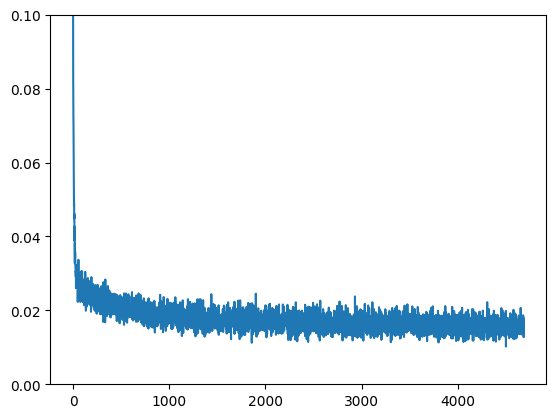

In [10]:
net = BasicUNet()
net.to(device)

EPOCHS = 10
BATCH_SIZE = 128
criterion = nn.MSELoss() #loss function
optim = torch.optim.Adam(net.parameters(), lr = 1e-3) 

train_dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

losses = []

for e in range(EPOCHS):
    for i, (x, y) in enumerate(train_dataloader):
        x = x.to(device)
        amount = torch.rand(x.shape[0]).to(device)
        x_noisy = corrupt(x, amount)
        pred = net(x_noisy)
        loss = criterion(pred, x)
        loss.backward()
        optim.step()
        optim.zero_grad()
        
        losses.append(loss.item())
    
    ave_loss = sum(losses[-len(train_dataloader ):]) / len(train_dataloader)
    print(f'Finished epoch {e} Average loss for this epoch: {ave_loss}')

plt.plot(losses)
plt.ylim(0, 0.1);

             

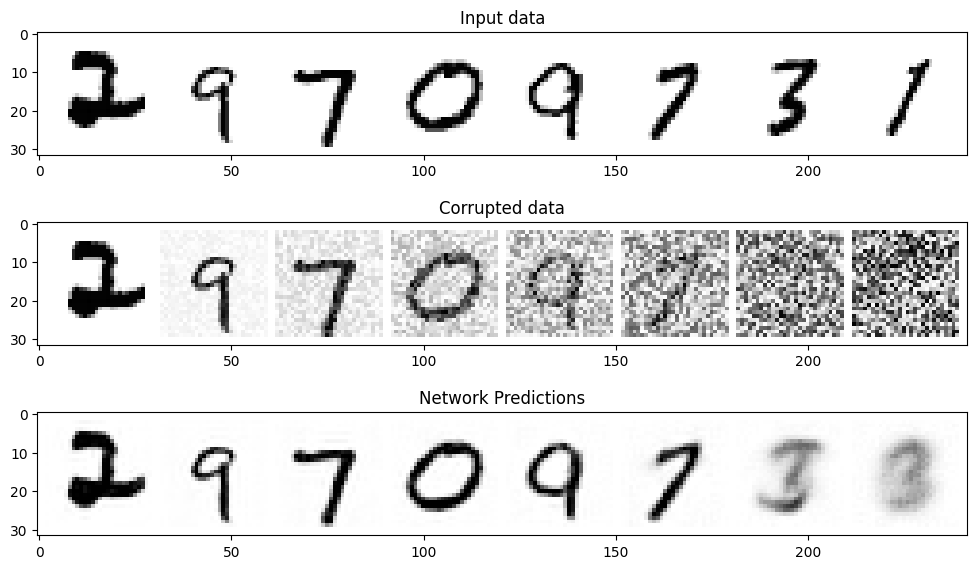

In [11]:
x, y = next(iter(train_dataloader))
x = x[:8]
amount = torch.linspace(0, 1, x.shape[0])
x_noised = corrupt(x, amount)
with torch.no_grad():
  preds = net(x_noised.to(device)).cpu()

fig, axs = plt.subplots(3, 1, figsize=(12, 7))

axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(x_noised)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

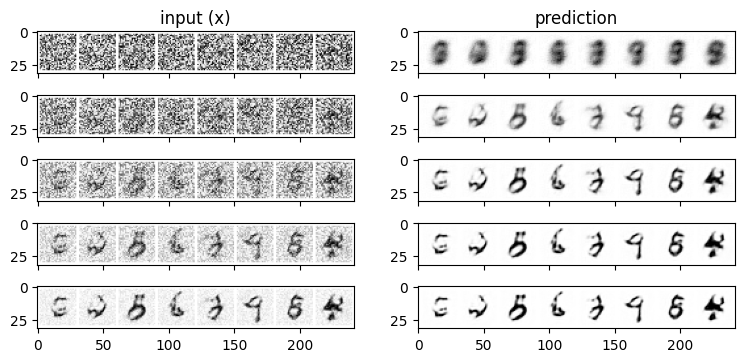

In [12]:
x = torch.rand(8, 1, 28, 28).to(device) # uniform distribution
num_step = 5
x_history = []
pred_history = []

x_history.append(x.detach().cpu())
for i in range(num_step):
  with torch.no_grad():
    pred = net(x)
  
  pred_history.append(pred.detach().cpu())
  mix_fac = 1 / (num_step - i)
  x = x * (1 - mix_fac) + pred * mix_fac
  x_history.append(x.detach().cpu())
  
fig, axs = plt.subplots(num_step, 2,  figsize=(9, 4), sharex=True)
axs[0,0].set_title('input (x)')
axs[0,1].set_title('prediction')

for i in range(num_step):
  axs[i, 0].imshow(torchvision.utils.make_grid(x_history[i])[0].clip(0, 1), cmap='Greys')
  axs[i, 1].imshow(torchvision.utils.make_grid(pred_history[i])[0].clip(0, 1), cmap='Greys')